<p style="text-align:center;">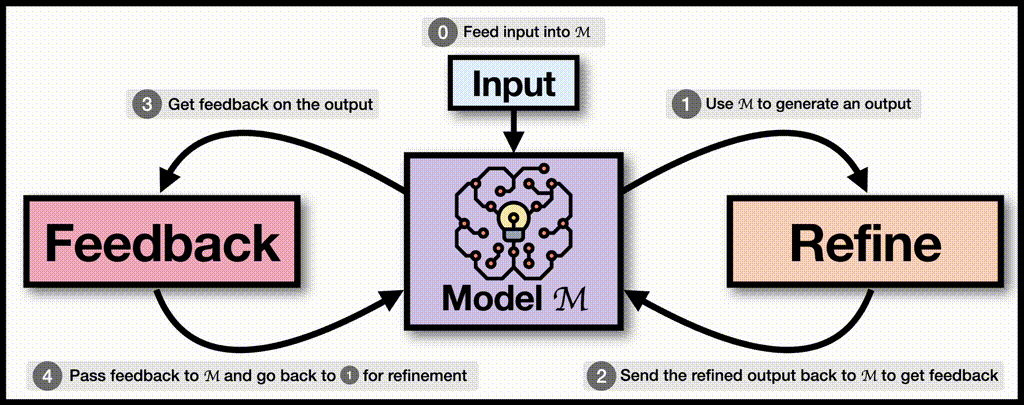<br>
Source: Madaan et al. [@madaan2023selfrefine]
</p>

Self-refine [@madaan2023selfrefine] is an approach that iteratively improves a model’s output based on its own feedback. It is suitable for stronger models. Given an initial output, it consists of 2 main steps: feedback and refine. The feedback contains concrete actions that can improve the output and identifies specific phrases in the output to be improved. Good feedback is cruicial for the approach to work.

Self-refine uses three prompts: initial generation, feedback and refinement. The authors used few-shot prompting as in-context learning to guide the model:

- Initial generation prompt: few-shot prompt plus input
- feedback prompt: few-shot prompt plus input and current output (initial output or the latest refined output)
- refine prompt: few-shot prompt plus input and the history of refinement.
    - examples in the few-shot prompt also include refinement history

This notebook experiments with self-refine for constrained generation using Gemini 1.5 models.

In [1]:
# | code-fold: true
# | code-summary: Import necessary libraries

import json
import nltk
import os
import re
import spacy
import sys
import time
import google.generativeai as genai

from google.ai.generativelanguage import Part, Content
from urllib.request import urlopen

sys.path.append('../src')
import utils

from dotenv import load_dotenv
load_dotenv();

# Prepare 3 prompt templates
All three prompt templates are constructed using data from authors' repo at [madaan/self-refine](https://github.com/madaan/self-refine).

## 1. init prompt template

In [2]:
#| code-fold: true
#| code-summary: Show the help functions

def download_examples(file_url):
    with urlopen(file_url) as f:
        lines = f.readlines()
    examples = list(map(lambda x: json.loads(x), lines))
    return examples

In [89]:
def construct_init_prompt_template():
    examples_url='https://raw.githubusercontent.com/madaan/self-refine/main/data/prompt/commongen/init.jsonl'
    examples = download_examples(examples_url)
    
    prompt_head = """
I want you to create a sentence that contains all the specified concepts.

Here are some examples:
    """.strip()
    prompt_end = """
Now create a sentence using the following concepts:

Concepts: {concepts}
The sentence is:
    """.strip()

    example_template = """
Concepts: {concepts}
The sentence is: {sentence}
    """.strip()
    
    examples_prompt = ''
    for example in examples:
        examples_prompt += '\n\n' + example_template.format(
            concepts=example['concepts'],
            sentence=example['target']
        )
    prompt_template = prompt_head + examples_prompt + '\n\n' + prompt_end
    return prompt_template

In [90]:
init_prompt_template = construct_init_prompt_template()
utils.display_html(init_prompt_template, 'Show init prompt template')

## 2. feedback prompt template

In [5]:
def construct_feedback_prompt_template():
    examples_url='https://raw.githubusercontent.com/madaan/self-refine/main/data/prompt/commongen/feedback.jsonl'
    examples = download_examples(examples_url)
    
    prompt_head = """
I want you to provide feedbacks on a sentence that is constructed using given concepts. \
Follow the following instructions:
- First, find out what concepts from the concept list are missing from the constructed sentence
- Second, if the sentence doesn't makes sense, provide short explanation; otherwise, provide "None" as your answer.

Here are some examples:
    """.strip()

    prompt_end ="""
Now provide your feedbacks on the following concepts and the constructed sentence.
- First, find out what concepts from the concept list are missing from the constructed sentence
- Second, if the sentence doesn't makes sense, provide short explanation; otherwise, provide "None" as your answer.

Concepts: {concepts}
Constructed sentence: {sentence}
    """.strip()

    example_template = """
Concepts: {concepts}
Constructed sentence: {sentence}
Missing concepts: {missing_concepts}
Commonsense Feedback: {commonsense_feedback}
    """.strip()
    
    examples_prompt = ''
    for example in examples:
        examples_prompt += '\n\n' + example_template.format(
            concepts=example['concepts'],
            sentence=example['sentence'],
            missing_concepts=', '.join(example['concept_feedback']).replace('NONE', 'None'),
            commonsense_feedback=example['commonsense_feedback'].replace('NONE', 'None')
        )

    prompt_template = prompt_head + examples_prompt + '\n\n' + prompt_end
    return prompt_template

In [6]:
feedback_prompt_template = construct_feedback_prompt_template()
utils.display_html(feedback_prompt_template, 'Show feedback prompt template')

## 3. refine prompt template

In [7]:
def construct_refine_prompt_templates():
    examples_url='https://raw.githubusercontent.com/madaan/self-refine/main/data/prompt/commongen/iterate.jsonl'
    examples = download_examples(examples_url)

    prompt_head = f"""
We are having multi-turn conversation in order to create a sentence that contains all given concepts. \
I will provide you with my feedbacks on the sentence regarding missing concepts and whether the sentence makes sense. \
Your task is to improve the provided sentence based on my feedbacks.

Here are {len(examples)} examples of our past conversations:
    """.strip()

    generation_prompt = 'Impove the sentence using the above feedbacks.'

    example_prompt_head = """
Example {i}:
User:
Concepts: {concepts}
Sentence: {sentence}
Missing concepts: {missing_concepts}
Commonsense Feedback: {commonsense_feedback}

{generation_prompt}
    """.strip()

    example_prompt_assistant = """
Assistant:
Sentence: {sentence}
    """.strip()

    example_prompt_user = """
User:
Missing concepts: {missing_concepts}
Commonsense Feedback: {commonsense_feedback}

{generation_prompt}
    """.strip()

    prompt_end_0 = """
Now let's start a new conversation so that you can improve a constructed sentence based on my feedbacks.

Concepts: {concepts}
Sentence: {sentence}
Missing concepts: {missing_concepts}
Commonsense Feedback: {commonsense_feedback}
    """.strip()

    prompt_end_1 = """
Missing concepts: {missing_concepts}
Commonsense Feedback: {commonsense_feedback}
    """.strip()
    
    examples_prompt = ''
    for i, example in enumerate(examples):
        sentence_to_feedback = example['sentence_to_feedback']
        examples_prompt += '\n\n' + example_prompt_head.format(
            i=i+1,
            concepts=example['concepts'],
            sentence=sentence_to_feedback[0]['sentence'],
            missing_concepts=sentence_to_feedback[0]['concept_feedback'],
            commonsense_feedback=sentence_to_feedback[0]['commonsense_feedback'],
            generation_prompt=generation_prompt
        )
        for x in sentence_to_feedback[1:]:
            examples_prompt += '\n' + example_prompt_assistant.format(sentence=x['sentence'])
            examples_prompt += '\n' + example_prompt_user.format(
                missing_concepts=x['concept_feedback'],
                commonsense_feedback=x['commonsense_feedback'],
                generation_prompt=generation_prompt
            )
        # remove the last generation_prompt
        idx = examples_prompt.rfind(generation_prompt)
        examples_prompt = examples_prompt[0:idx].strip()
        
    prompt_template_0 = prompt_head+ '\n\n' + examples_prompt + '\n\n' + prompt_end_0 + '\n\n' + generation_prompt
    prompt_template_1 = prompt_end_1 + '\n\n' + generation_prompt
    return prompt_template_0, prompt_template_1

In [8]:
refine_prompt_template_0, refine_prompt_template_1 = construct_refine_prompt_templates()
utils.display_html(refine_prompt_template_0, 'Show refine prompt template for the first refinement')
utils.display_html(refine_prompt_template_1, 'Show refine prompt template for the rest refinement')

# Experiments

In [9]:
def ask_llm(prompt, model):
    response = model.generate_content(prompt)
    return response.text.strip()
    
# a help function to remove prefix from model's outputs
def remove_prefix_if_exist(prefix, text):
    if prefix in text.lower():
        start_idx = text.lower().index(prefix) + len(prefix)
        text = text[start_idx:].strip()
    return text

In [67]:
nlp = spacy.load("en_core_web_sm")

def concepts_from_sentence(sentence, concepts):
    """extract concepts from a sentence using NLTK and spacy."""
    words = nltk.word_tokenize(sentence)
    lemmas = [t.lemma_ for t in nlp(sentence)]
    tokens = set(words + lemmas)
    
    found_concepts = set(concepts).intersection(tokens)
    return found_concepts

def fix_missing_concepts(concept_feedback, found_concepts):
    """fix model's concept feedback if there are any mistakes."""
    words = concept_feedback.split(',')
    words = map(lambda x: x.strip(), words)
    words = set(filter(lambda x: len(x)>0, words))    
    missing_concepts = words.difference(found_concepts)
    if missing_concepts:
        return ', '.join(missing_concepts)
    else:
        return 'None'

def process_feedback_outputs(outputs):
    concept_feedback, commonsense_feedback = outputs.split('\n',maxsplit=1)
    concept_feedback = remove_prefix_if_exist('missing concepts:', concept_feedback)
    commonsense_feedback = remove_prefix_if_exist('commonsense feedback:', commonsense_feedback)
    return concept_feedback, commonsense_feedback

In [11]:
def get_feedback(sentence, concepts, model):
    found_concepts = concepts_from_sentence(sentence, concepts)
    
    feedback_prompt = feedback_prompt_template.format(concepts=concepts, sentence=sentence)
    feedback_outputs = ask_llm(feedback_prompt, model)
    print(f'{"="*10} DEBUG {"="*10}')
    print(f'Sentence: {sentence}')
    print(feedback_outputs)
    print(f'{"-"*10}-------{"-"*10}')
    
    concept_feedback, commonsense_feedback = process_feedback_outputs(feedback_outputs)
    fixed_missing_concepts = fix_missing_concepts(concept_feedback, found_concepts)
    return fixed_missing_concepts, commonsense_feedback

In [19]:
def run_refine_loop(sentence, concepts, model, max_tries=5, throttle=False, throttle_value=5):
    refine_gen_prefix = 'sentence:'
    refine_prompt_template = refine_prompt_template_0
    chat = model.start_chat()
        
    for i in range(max_tries):
        start_time = time.perf_counter()
        missing_concepts, commonsense_feedback = get_feedback(sentence, concepts, model)
        if 'none' == missing_concepts.lower() and 'none' == commonsense_feedback.lower():
            if i != 0:
                chat.history.append(Content(
                    role='user',
                    parts=[Part(text='Missing concepts: None\nCommonsense Feedback: None')])
                )
            return sentence, chat.history

        if throttle:
            utils.throttle(start_time, throttle_value)

        start_time = time.perf_counter()
        refine_prompt = refine_prompt_template.format(
            concepts=concepts,
            sentence=sentence,
            missing_concepts=missing_concepts,
            commonsense_feedback=commonsense_feedback
        )
        refine_outputs = chat.send_message(refine_prompt).text.strip()
        
        if refine_gen_prefix in refine_outputs.lower():
            start_idx = refine_outputs.lower().index(refine_gen_prefix) + len(refine_gen_prefix)
            sentence = refine_outputs[start_idx:].strip()
        else:
            sentence = refine_outputs

        if i == 0:
            refine_prompt_template = refine_prompt_template_1

        if throttle:
            utils.throttle(start_time, throttle_value)

    missing_concepts, commonsense_feedback = get_feedback(sentence, concepts, model)
    parts_text = f'Missing concepts: {missing_concepts}\nCommonsense Feedback: {commonsense_feedback}'
    chat.history.append(Content(
        role='user', 
        parts=[Part(text=parts_text)])
    )

    return sentence, chat.history

## Configure both `gemini-1.5-flash` and `gemini-1.5-pro` models.

In [13]:
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])
safe = [
    {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"}
]

model_flash = genai.GenerativeModel(
    'gemini-1.5-flash-001',
    safety_settings=safe,
    system_instruction='You are a helpful assistant. Avoid markdown in your response. Plain text only.',
    generation_config={'temperature': 0.7, 'max_output_tokens': 256}
)
model_pro = genai.GenerativeModel(
    'gemini-1.5-pro-001',
    safety_settings=safe,
    system_instruction='You are a helpful assistant. Avoid markdown in your response. Plain text only.',
    generation_config={'temperature': 0.7, 'max_output_tokens': 256}
)

## Exp 01: using `gemini-1.5-flash`
### 1. generate the initital sentence

In [14]:
# an example from authors' [commongen_hard.jsonl](https://github.com/madaan/self-refine/blob/main/data/prompt/commongen/commongen_hard.jsonl)
concepts = ["use", "goat", "wine", "frisbee",
            "leap", "pole", "tell", "pencil",
            "spin", "birdie", "catcher", "fence",
            "world", "step", "chop", "sword",
            "march", "stage", "axe", "bat",
            "place", "roller", "tomato"]
init_prompt = init_prompt_template.format(concepts=concepts)

utils.display_html(init_prompt, 'Show init prompt')

In [83]:
init_outputs = ask_llm(init_prompt, model_flash)
sentence = remove_prefix_if_exist('the sentence is:', init_outputs)
sentence

'The goat leaps over the fence, using the frisbee as a springboard, while the world spins around him; a catcher tells the story of a place where they chop tomatoes with a sword, march on stage with an axe, and bat a roller with a pencil.'

### 2. run the refine loop

In [84]:
sentence, history = run_refine_loop(sentence, concepts, model_flash)

========== DEBUG ==========
Sentence: The goat leaps over the fence, using the frisbee as a springboard, while the world spins around him; a catcher tells the story of a place where they chop tomatoes with a sword, march on stage with an axe, and bat a roller with a pencil.
Missing concepts: use, wine, pole, birdie, step, axe, bat
Commonsense Feedback: The sentence does not make sense because a goat cannot use a frisbee as a springboard and a catcher cannot chop tomatoes with a sword, march on stage with an axe, and bat a roller with a pencil.
---------------------------
========== DEBUG ==========
Sentence: The goat leaps over the fence, using a pole to step over it, while the world spins around him; a catcher tells the story of a place where they chop tomatoes with an axe, march on stage with a sword, and bat a roller with a pencil, while a birdie uses a wine glass to spin a frisbee.
Missing concepts: None
Commonsense Feedback: The sentence does not make sense because it is a nonsens

In [85]:
sentence

'A goat leaps over a fence, using a pole to step over it, as the world spins around him. A catcher tells a story of a place where people chop tomatoes with an axe, march on stage with a sword, and bat a roller with a pencil. A birdie spins a frisbee in the air, taking a sip of wine as it does so.'

In [87]:
last_feedback = history[-1].parts[0].text
print(last_feedback)

Missing concepts: None
Commonsense Feedback: The sentence does not make sense because a goat cannot use a pole to step over a fence, a catcher cannot tell a story of a place where people chop tomatoes with an axe, march on stage with a sword, and bat a roller with a pencil, and a birdie cannot spin a frisbee in the air while taking a sip of wine.


In [86]:
utils.display_html(history, 'Show refine history')

## Exp 02: using `gemini-1.5-pro`
### 1. generate the initital sentence

In [69]:
init_prompt = init_prompt_template.format(concepts=concepts)
utils.display_html(init_prompt, 'Show init prompt')

In [26]:
init_outputs = ask_llm(init_prompt, model_pro)

sentence = remove_prefix_if_exist('the sentence is:', init_outputs)
sentence

'The goat, perched atop the fence post, watched the world go by: a frisbee spinning through the air, a birdie leaping over a badminton net, a tomato rolling off a chopping board.'

### 2. run the refine loop

In [73]:
sentence, history = run_refine_loop(sentence, concepts, model_pro)

========== DEBUG ==========
Sentence: The goat, perched atop the fence post, watched the world go by: a frisbee spinning through the air, a birdie leaping over a badminton net, a tomato rolling off a chopping board.
Missing concepts: use, wine, pole, tell, pencil, catcher, step, chop, sword, march, stage, axe, bat, place, roller 
Commonsense Feedback: None
---------------------------
========== DEBUG ==========
Sentence: The goat, perched atop the fence post, watched the world go by: a frisbee spinning through the air, a birdie leaping over a badminton net, a tomato rolling off a chopping board, as a marching band stepped onto the stage, the drummer using pencils as drumsticks.
Missing concepts: wine, tell, catcher, chop, sword, axe, bat, place, roller 
Commonsense Feedback: None
---------------------------
========== DEBUG ==========
Sentence: The goat, perched atop the fence post, watched the world go by: a frisbee spinning through the air, a birdie leaping over a badminton net, a to

In [74]:
sentence

'The goat, perched atop the fence post, watched the world go by: a frisbee spinning through the air, a birdie leaping over a badminton net, a tomato rolling off a chopping board as a chef chops it with an axe, a baseball player swinging a bat, missing the ball which is caught by the catcher, and a marching band stepping onto the stage, the drummer using pencils as drumsticks. A street performer, balancing a sword on his nose, tells jokes as he juggles wine bottles. A nearby painter, using a roller to paint the scenery, accidentally knocks over a pole.'

In [80]:
last_feedback = history[-1].parts[0].text
print(last_feedback)

Missing concepts: None
Commonsense Feedback: None


In [75]:
utils.display_html(history, 'Show refine history')